In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import itertools
import math
import os
import pickle
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# main.py resets stdout, so keep a reference here
import sys
stdout = sys.stdout

In [3]:
import helper

In [4]:
from main import *
sys.stdout = stdout

TensorFlow Version: 1.2.1
Tests Passed
Tests Passed
Tests Passed


/Users/john/carnd/CarND-Semantic-Segmentation/main.py:15: UserWarning: No GPU found. Please use a GPU to train your neural network.
  warnings.warn('No GPU found. Please use a GPU to train your neural network.')


# Setup

## Example Images

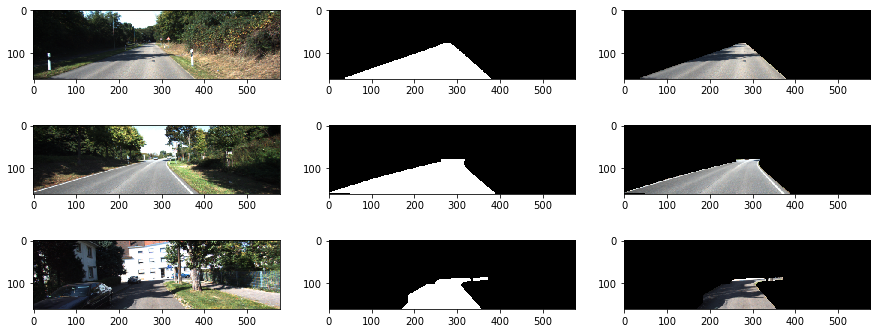

In [5]:
def show_example_images(num_images):
    get_batches_fn = helper.gen_batch_function(
        os.path.join(DATA_DIR, 'data_road/training'), IMAGE_SHAPE)
    
    fig, axes = plt.subplots(
        num_images, 3,
        figsize=(15, 2*num_images))

    i = 0
    for inputs, labels in itertools.islice(get_batches_fn(1), num_images):
        axes[i][0].imshow(inputs[0])
        road_mask = labels[0,:,:,1]
        axes[i][1].imshow(road_mask, cmap='gray')
        axes[i][2].imshow(inputs[0] * road_mask[:,:,np.newaxis])
        i += 1
show_example_images(3)

# Training

## Train / Validation Split

The `helper.gen_batch_function` returns a generator that returns the images in shuffled order, so we just have to cut the total training set into a training set and a validation set; we use a roughly 80/20 split. Pickle the data for fast access later.

In [6]:
TRAINING_FILE = os.path.join(DATA_DIR, 'train_1.pickle')
VALIDATION_FILE = os.path.join(DATA_DIR, 'validation_1.pickle')

NUM_TOTAL_TRAINING_IMAGES = 289
NUM_TRAINING_IMAGES = 230
NUM_VALIDATION_IMAGES = NUM_TOTAL_TRAINING_IMAGES - NUM_TRAINING_IMAGES

def save_input_and_labels(pathname, inputs, labels):
    with open(pathname, 'wb') as file:
        pickle.dump({
            'inputs': inputs,
            'labels': labels
        }, file, pickle.HIGHEST_PROTOCOL)

def generate_training_validation_split():
    if os.path.exists(TRAINING_FILE):
        print('Training set already exists.')
        return
    
    get_batches_fn = helper.gen_batch_function(
        os.path.join(DATA_DIR, 'data_road/training'), IMAGE_SHAPE)
    
    training_inputs = []
    training_labels = []
    validation_inputs = []
    validation_labels = []
    i = 0
    for inputs, labels in get_batches_fn(1):
        if i < NUM_TRAINING_IMAGES:
            training_inputs.append(inputs[0])
            training_labels.append(labels[0])
        else:
            validation_inputs.append(inputs[0])
            validation_labels.append(labels[0])
        i += 1
        
    save_input_and_labels(
        TRAINING_FILE,
        np.array(training_inputs),
        np.array(training_labels))
    save_input_and_labels(
        VALIDATION_FILE,
        np.array(validation_inputs),
        np.array(validation_labels))
        
generate_training_validation_split()

Training set already exists.


In [7]:
def load_input_and_labels(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
        return data['inputs'], data['labels']
        
TRAINING_INPUTS, TRAINING_LABELS = load_input_and_labels(TRAINING_FILE)
VALIDATION_INPUTS, VALIDATION_LABELS = load_input_and_labels(VALIDATION_FILE)

# for testing
# TRAINING_INPUTS = TRAINING_INPUTS[:5,:,:,:]
# TRAINING_LABELS = TRAINING_LABELS[:5,:,:,:]
# VALIDATION_INPUTS = VALIDATION_INPUTS[:3,:,:,:]
# VALIDATION_LABELS = VALIDATION_LABELS[:3,:,:,:]

In [8]:
[TRAINING_INPUTS.shape, VALIDATION_INPUTS.shape]

[(230, 160, 576, 3), (59, 160, 576, 3)]

## Tune

In [9]:
# From http://stackoverflow.com/a/40623158/2053820
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [10]:
GRID_FILE = os.path.join(DATA_DIR, 'grid_1.pickle')

def run_grid_point(params):
    params = params.copy()
    batch_size = params.pop('batch_size')
    min_epochs_without_progress = params.pop('min_epochs_without_progress')
    max_epochs = params.pop('max_epochs')
    keep_prob_value = params.pop('keep_prob')
    learning_rate_value = params.pop('learning_rate')
    
    num_training_batches = \
        int(math.ceil(TRAINING_INPUTS.shape[0] / batch_size))
    num_validation_batches = \
        int(math.ceil(VALIDATION_INPUTS.shape[0] / batch_size))
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        train_op, cross_entropy_loss, image_input, correct_label, \
            keep_prob, learning_rate, logits = build(sess, params)
            
        mean_iou, mean_iou_update_op = tf.metrics.mean_iou(
            tf.reshape(correct_label[:,:,:,1], [-1]),
            tf.nn.softmax(logits)[:,1] > 0.5,
            NUM_CLASSES)

        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        start = timer()
        epochs_without_progress = 0
        best_epoch = 0
        best_validation_loss = math.inf
        best_mean_iou = 0
        for epoch in range(max_epochs):
            if epochs_without_progress > min_epochs_without_progress:
                break
            
            for batch in range(num_training_batches):
                batch_start = batch * batch_size
                batch_end = batch_start + batch_size
                batch_inputs = TRAINING_INPUTS[batch_start:batch_end,:,:,:]
                batch_labels = TRAINING_LABELS[batch_start:batch_end,:,:,:]
                training_loss, _ = sess.run(
                    [cross_entropy_loss, train_op], {
                        image_input: batch_inputs,
                        correct_label: batch_labels,
                        keep_prob: keep_prob_value,
                        learning_rate: learning_rate_value
                    }
                )
                print('training', epoch, batch, training_loss)
            
            validation_loss = 0
            validation_mean_iou = 0
            for batch in range(num_validation_batches):
                batch_start = batch * batch_size
                batch_end = batch_start + batch_size
                batch_inputs = VALIDATION_INPUTS[batch_start:batch_end,:,:,:]
                batch_labels = VALIDATION_LABELS[batch_start:batch_end,:,:,:]
                batch_loss, batch_mean_iou, _ = sess.run(
                    [cross_entropy_loss, mean_iou, mean_iou_update_op], {
                        image_input: batch_inputs,
                        correct_label: batch_labels,
                        keep_prob: 1.0
                    }
                )
                actual_batch_size = batch_inputs.shape[0]
                validation_loss += actual_batch_size * batch_loss
                validation_mean_iou += actual_batch_size * batch_mean_iou
            
            validation_loss /= NUM_VALIDATION_IMAGES
            validation_mean_iou /= NUM_VALIDATION_IMAGES

            print('validation', epoch, validation_loss, validation_mean_iou)
            
            if validation_loss < best_validation_loss:
                best_epoch = epoch
                best_validation_loss = validation_loss
                best_mean_iou = validation_mean_iou
                epochs_without_progress = 0
            else:
                epochs_without_progress += 1
            
        return {
            'best_epoch': best_epoch,
            'best_validation_loss': best_validation_loss,
            'best_mean_iou': best_mean_iou,
            'time': timer() - start,
        }
            
def run_grid():
    if os.path.isfile(GRID_FILE):
        with open(GRID_FILE, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}
        
    params_dict = {
        'batch_size': [13],
        'min_epochs_without_progress': [3],
        'max_epochs': [10],
        'keep_prob': [0.5],
        'learning_rate': [0.0001],
        'kernel_size_3': [16],
        'kernel_size_4': [4],
        'kernel_size_7': [4],
        'conv_1x1_depth': [0, 4096]
    }
    
    for params in dict_product(params_dict):
        print(params)
        
        frozen_key = frozenset(params.items())
        if frozen_key in results:
            continue
            
        results[frozen_key] = run_grid_point(params)
        
        with open(GRID_FILE, 'wb') as f:
            pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
        
run_grid()

{'min_epochs_without_progress': 3, 'kernel_size_4': 4, 'max_epochs': 10, 'batch_size': 13, 'keep_prob': 0.5, 'conv_1x1_depth': 0, 'learning_rate': 0.0001, 'kernel_size_3': 16, 'kernel_size_7': 4}
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
training 0 0 63.9371
training 0 1 31.8687
training 0 2 21.0092
training 0 3 16.4693
training 0 4 14.2903
training 0 5 12.9714
training 0 6 11.0827
training 0 7 6.54776
training 0 8 5.00507
training 0 9 3.80922
training 0 10 3.32584
training 0 11 2.93431
training 0 12 3.30332
training 0 13 2.40925
training 0 14 2.28666
training 0 15 1.74723
training 0 16 1.65325
training 0 17 1.58324
validation 0 1.35324096276 0.511603764558
training 1 0 1.43186
training 1 1 1.2543
training 1 2 1.2158
training 1 3 1.09069
training 1 4 0.955299
training 1 5 1.02593
training 1 6 0.929838
training 1 7 0.79545
training 1 8 0.789705
training 1 9 0.720338
training 1 10 0.93198
training 1 11 0.574993
training 1 12 0.767356
training 1 13 0.7196

In [11]:
def summarize_grid(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        
    print(results)
    
summarize_grid(GRID_FILE)

{frozenset({('max_epochs', 10), ('kernel_size_7', 4), ('learning_rate', 0.0001), ('keep_prob', 0.5), ('conv_1x1_depth', 0), ('kernel_size_4', 4), ('batch_size', 13), ('kernel_size_3', 16), ('min_epochs_without_progress', 3)}): {'best_epoch': 9, 'best_validation_loss': inf, 'time': 14972.77307708899, 'best_mean_iou': 0.76595317307165112}, frozenset({('max_epochs', 10), ('kernel_size_7', 4), ('learning_rate', 0.0001), ('keep_prob', 0.5), ('conv_1x1_depth', 4096), ('kernel_size_4', 4), ('batch_size', 13), ('kernel_size_3', 16), ('min_epochs_without_progress', 3)}): {'best_epoch': 9, 'best_validation_loss': inf, 'time': 14837.832148092974, 'best_mean_iou': 0.76487153061365676}}
